# Monte Carlo Methods

In this notebook, it's implementations of many Monte Carlo (MC) algorithms. we use [blackjack game](https://games.washingtonpost.com/games/blackjack) as a environment to illustrate this method.


## Part 0: Explore BlackjackEnv

In [1]:
import sys
import gymnasium as gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

np.random.seed(0)

Use the code cell below to create an instance of the [Blackjack](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/blackjack.py) environment.

In [2]:
env = gym.make('Blackjack-v1')

$S$ Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

$A$ The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Part 1: MC Prediction

In this section, we will implement **MC prediction** for estimating the action-value function $q_{\pi}(s, a)$. 

**Prediction Problem**:
- Algorithms that solve the prediction problem determine the value function $v_{\pi}(s)$ or $q_{\pi}(s, a)$ corresponding to a policy $\pi$

**Policy $\pi$**: 
- We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  
- In particular, it selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.

**Trajectory**:

The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

**input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

**output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  

In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [4]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state, info = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8] # policy
        action = np.random.choice(np.arange(2), p=probs) # sampling from pi(a|s)
        next_state, reward, done, truncated, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [5]:
# play Blackjack with the policy.
for i in range(3):
    print(f"Episode {i}: ", generate_episode_from_limit_stochastic(env))

Episode 0:  [((20, 4, 0), np.int64(0), -1.0)]
Episode 1:  [((12, 10, 0), np.int64(0), -1.0)]
Episode 2:  [((9, 8, 0), np.int64(1), 0.0), ((15, 8, 0), np.int64(0), -1.0)]


In [6]:
generate_episode_from_limit_stochastic(env)

[((13, 9, 0), np.int64(1), -1.0)]

### MC prediction

- Option 1: Every-visit MC Prediction
	- Average the returns following all visits to each state-action pair, in all episodes.

- Option 2: First-visit MC Prediction
	- For each episode, we only consider the first visit to the state-action pair. The pseudocode for this option can be found below.

In here, we use First-Visit MC Prediction. The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

- Psedocode
![psedocode](./images/monte-carlo-first-visit-prediction.png)

- Compute method illustration
![action-value-function](./images/action-value-function-compute.png)

In [7]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate an trajectory sequence using policy
        episode = generate_episode(env)

        # compute return
        states, actions, rewards = zip(*episode)
        # here we add additional gamma factor[len(rewards)+1)] but not use
        # just for convenience of below vectorization
        discouts = np.array([gamma**i for i in range(len(rewards)+1)])

        visited = set() # comment this to use every-visit
        for i, state in enumerate(states):
            sa_pair = (state, actions[i]) # comment this to use every-visit
            if sa_pair not in visited: # comment this to use every-visit
                visited.add(sa_pair) # comment this to use every-visit
                # using above illustrated figure to compute action-value function
                # vectorization version
                returns_sum[state][actions[i]] += sum(rewards[i:] * discouts[:-(i+1)]) 
                N[state][actions[i]] += 1
                Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]

    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

$$
\begin{align}
\text{Estimate } Q(s, a) \\
\pi \rightarrow \{A_t, S_{t+1}, A_{t+1}, \cdots, S_n, A_n\} \\
V_{\pi}(s_t) = \mathbb{E}_{\pi}[G_t \mid S=s_t] \\
V_{\pi}(s_t) = \sum_{a\in{A(s_t)}} \pi(a \mid s_t) Q(s_t, a) \\
\end{align}
$$

Episode 500000/500000.

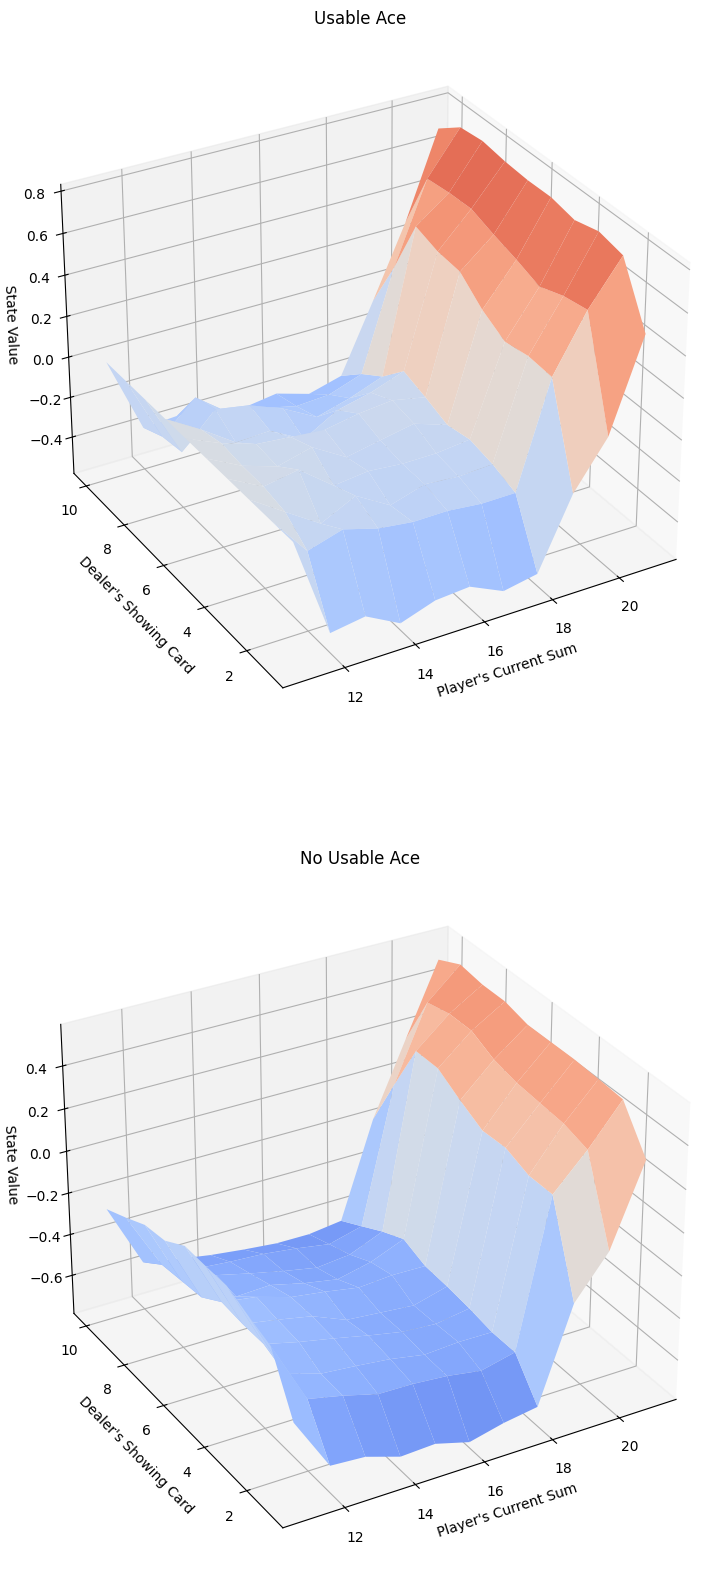

In [8]:
# obtain the action-value function, see above eq (1)
# in Q matrix, each row is one state, each column in each row is one action
#              value in each cell is current return value G_t
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic) 

# obtain the corresponding state-value function, see above eq (4)
# (k[0] > 18) * (np.dot([0.8, 0.2], v)) + (k[0] <= 18) * (np.dot([0.2, 0.8], v)) is
# vectorization version of eq (4)
V_to_plot = dict(
    (k, (k[0] > 18) * (np.dot([0.8, 0.2], v)) + (k[0] <= 18) * (np.dot([0.2, 0.8], v)))
    for k, v in Q.items() # for each state
)

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Discussion

In current algorithm, we collect a large number of episodes to build the Q-table (as an estimate for the action-value function corresponding to the agent's current policy)

In future, after the values in the Q-table have converged, we use the Q table to come up with an improved policy.

![](./images/mc-control.png)

But it is less efficient, **maybe update the Q-table after every episode**. Then, the updated Q-table could be used to improve the policy. That new policy could then be used to generate the next episode, and so on.

![](./images/mc-control-incremental-mean.png)

How it works for step 2:
![](./images/incremental-mean-compute-method.png)

In this case, even though we're updating the policy before the values in the Q-table accurately approximate the action-value function, this lower-quality estimate nevertheless still has enough information to help us propose successively better policies

## Part 2: MC Control Incremental Mean

**Control Problem**:
- Algorithms designed to solve the control problem determine the optimal policy $\pi_*$ from interaction with the environment.

![](./images/first-visit-glie-mc-control.png)

notes:

- **$Q$**:  
   - The **Q-table**, with a row for each state and a column for each action.  
   - The entry corresponding to state **$s$** and action **$a$** is denoted **$Q(s, a)$**.
- **$N$**: A table that keeps track of the number of first visits to each state-action pair.  
- **num_episodes**: The number of episodes the agent collects.  

- The algorithm proceeds by looping over the following steps:
	- Step 1: The policy **$π$** is improved to be **ϵ-greedy**(see details in below) with respect to **$Q$**, and the agent uses **$π$** to collect an episode.
	- Step 2: **$N$** is updated to count the total number of first visits to each state-action pair.
	- Step 3: The estimates in **$Q$** are updated to take into account the most recent information.

In this way, the agent is able to **improve the policy after every episode**!

### Epsilon-greedy policy
From psedocode and illustration figure, we use epsilon-greedy policy instead of greedy policy, The reason is that a successful RL agent cannot act greedily at every time step (that is, it cannot always exploit its knowledge); instead, in order to discover the optimal policy, it has to continue to explore the range of possibilities by visiting every state-action pair, This motivated the idea of an ϵ-greedy policy.

Basically, when an agent observes a state, it flips the coin:

- **If the coin lands tails** (with probability **$1 − ϵ$**), the agent selects the **greedy action** (the action that maximizes **$Q(s, a)$**).
- **If the coin lands heads** (with probability **$ϵ$**), the agent selects an action **uniformly at random** from all available actions (both greedy and non-greedy).

Specifically, to construct a policy **$π$** that is ϵ-greedy with respect to the current action-value function estimate **$Q$**, the probabilities are defined as:

- For the action **$a$** that maximizes **$Q(s, a)$**: $π(a | s) = 1 − ϵ + \frac{ϵ}{|A(s)|}$

- For all other actions: $π(a | s) = \frac{ϵ}{|A(s)|}$

Where:
- **$A(s)$** is the set of all possible actions in state **s**.
- **$|A(s)|$** is the number of possible actions (including the optimal one).

> Note:
> 1. The extra term **$\frac{ϵ}{|A(s)|}$** for the optimal action ensures that the total probability sums to 1.  
>   - The sum of probabilities for non-optimal actions is:
>      $$(|A(s)| − 1) × \frac{ϵ}{|A(s)|}$$
>      
>    - Adding this to the probability of the optimal action:
>      $$1 − ϵ + \frac{ϵ}{|A(s)|} $$
>
>      ensures the total probability equals 1.
> 
> 2. **ϵ** must always be in the range **$[0, 1]$**:
>    - **$ϵ = 0$**: Fully greedy policy.
>    - **$ϵ = 1$**: Fully random policy.


### Greedy in the Limit with Infinite Exploration (GLIE)

To ensure that **Monte Carlo (MC) control** converges to the optimal policy (**$π^*$**), two conditions must be satisfied, collectively known as **Greedy in the Limit with Infinite Exploration (GLIE)**:

1. **Every state-action pair** $(s, a)$ is visited infinitely many times.
2. The policy converges to a **greedy policy** with respect to the action-value function estimate **$Q$**.

These conditions ensure:
- The agent **continues to explore** for all time steps.
- The agent **gradually exploits more** (and explores less) over time.

One way to satisfy these conditions is by adjusting the value of **ϵ** in an **ϵ-greedy policy**. Specifically:
- **$\epsilon_i > 0$** for all time steps **i**.
- **$\epsilon_i$** decays to zero as **$i → ∞$** (e.g., **$lim_{i → ∞} ϵ_i = 0$**).

While GLIE guarantees convergence, it may take an impractically long time (e.g., trillions of episodes) to recover the optimal policy. In practice, better results can often be achieved by:

1. Using a **fixed $ϵ$** value.
2. Allowing **$ϵ_i$** to decay to a small positive value (e.g., 0.1).

Key considerations:
- A decay rate that is **too fast** can lead to poor exploration early in training.
- By the end of training, **$ϵ$** should be small enough for the agent to have converged to the optimal policy.

In [11]:
def epsilon_greedy(actions, epsilon):
    nA = len(actions)
    probs = np.ones(nA) * (epsilon / nA) # propability of non-greedy actions

    best_action = np.argmax(actions)
    probs[best_action] = 1 - epsilon + (epsilon / nA) # propability of greedy actions

    return probs


def mc_control_incremental_mean(env, num_episodes, eps_decay=0.999, eps_min=0.05, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    epsilon = 1.0
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # here epsilon annealed linearly from 1.0 to 0.1 over the first certain frames, 
        # and fixed at 0.1 thereafter.
        # see details: https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
        epsilon = max(epsilon*eps_decay, eps_min)
        
        # generate an episode
        episode = []
        state, info = env.reset()
        while True:
            probs = epsilon_greedy(Q[state], epsilon)
            action = np.random.choice(np.arange(nA), p=probs) if state in Q else env.action_space.sample()
            next_state, reward, done, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break

        # update Q table
        states, actions, rewards = zip(*episode)
        discount = np.array([gamma**i for i in range(len(states)+1)])

        visited = set()
        for i, state in enumerate(states): 
            sa_pair = (state, actions[i])
            if sa_pair not in visited:
                visited.add(sa_pair)
                N[state][actions[i]] += 1

                G = sum(rewards[i:] * discount[:-(i+1)])
                Q[state][actions[i]] += (1/N[state][actions[i]]) * (G - Q[state][actions[i]])

    policy = {k: np.argmax(v) for k, v in Q.items()}

    return policy, Q

In [12]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control_incremental_mean(env, 500000)

Episode 500000/500000.

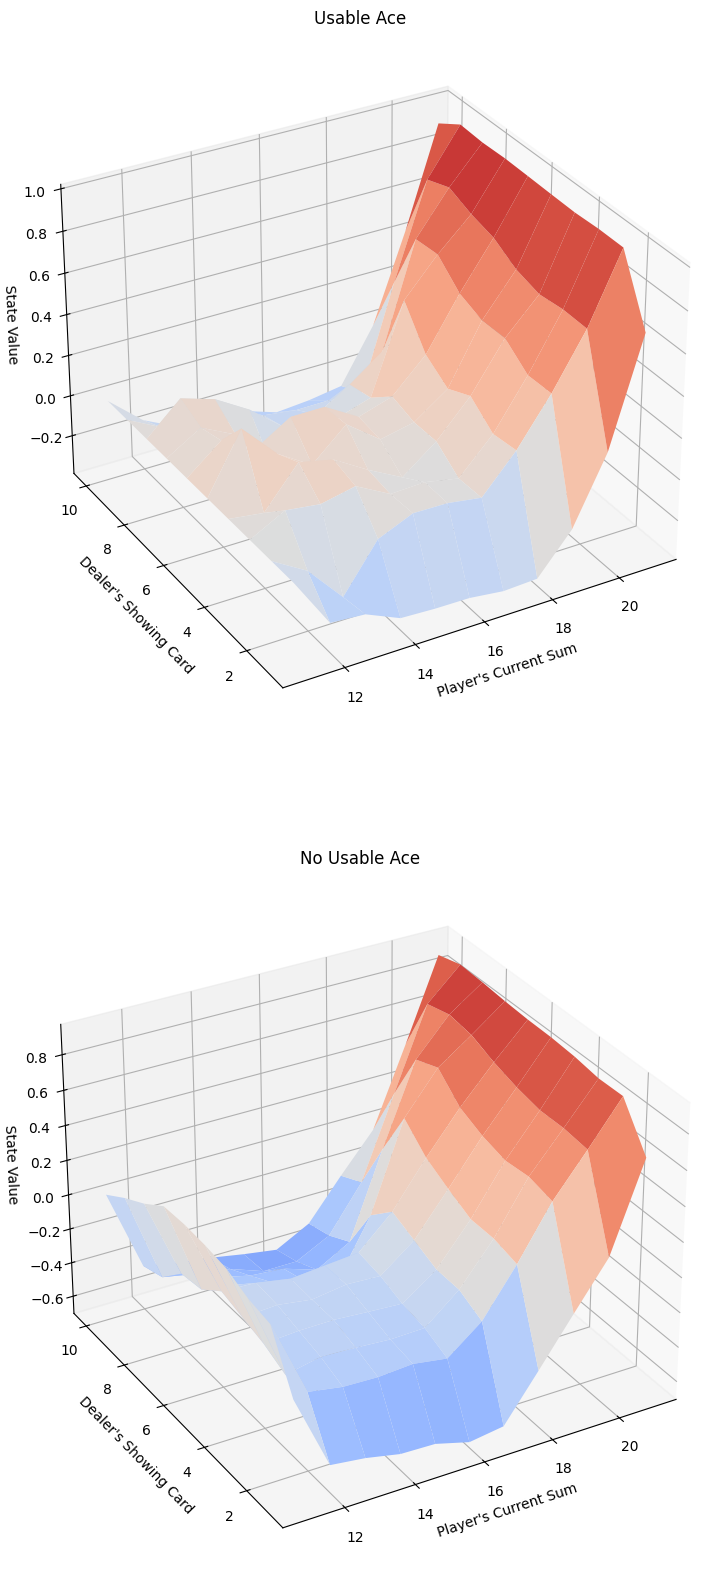

In [13]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

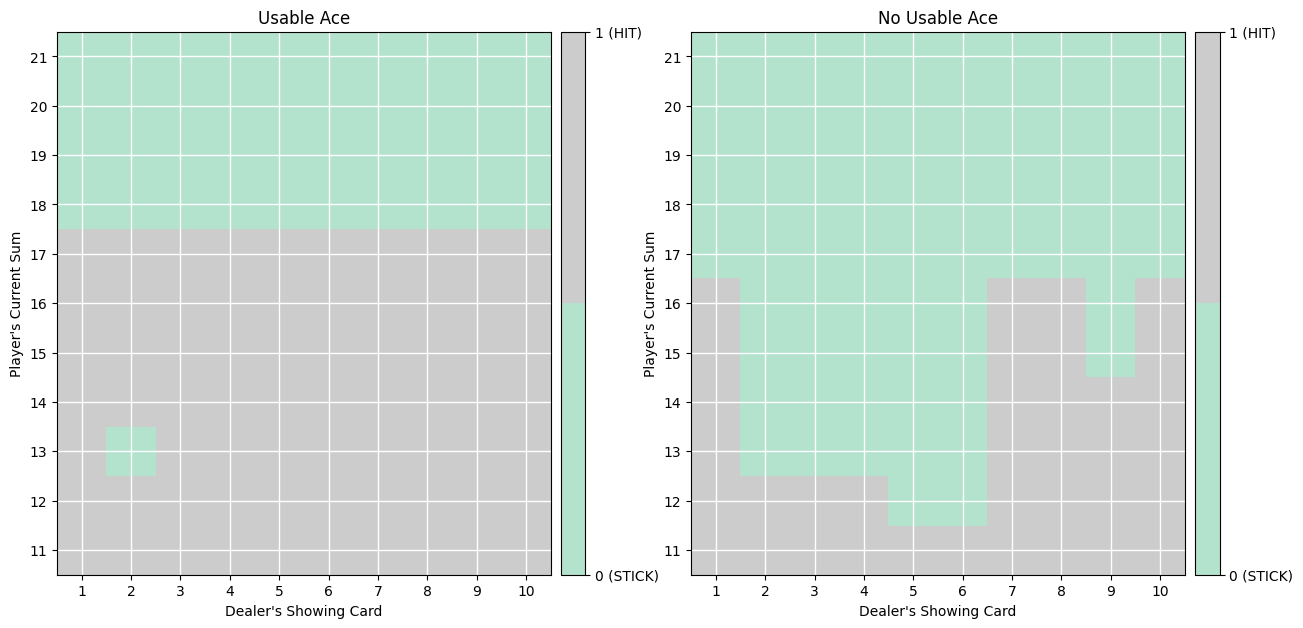

In [14]:
# plot the policy
plot_policy(policy)

### Discussion
For below's equation:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \frac{1}{N(S_t, A_t)} \cdot (G_t - Q(S_t, A_t))
$$

the learning rate is implicitly determined by $ \frac{1}{N(S_t, A_t)} $, where $ N(S_t, A_t) $ is the number of times the state-action pair $ (S_t, A_t) $ has been visited. This approach works well for algorithms that rely on averaging returns over multiple visits, as the learning rate naturally decreases over time as more samples are collected.

However, if we transform above equation to below 

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \cdot (G_t - Q(S_t, A_t))
$$

by introducing a fixed or dynamic learning rate $ \alpha $, which allows for **greater control** over the update process. By decoupling the learning rate from the visit count, the algorithm gains flexibility in balancing the influence of new information ($ G_t $) and historical estimates ($ Q(S_t, A_t) $). This is particularly useful in scenarios where a constant or adaptive learning rate is preferred, such as in non-stationary environments or when faster convergence is desired.

The core idea of this equation is to adjust the Q-value using the error, gradually moving it closer to the true return value.

- **$(1 - α)$**: Represents the weight given to the current Q-value.
- **$α$**: Represents the weight given to the new return $G_t$.

This rewritten form highlights that **$α$** balances the influence of the "historical estimate" and the "new sampled return":

To better understand the role of **α**, the equation is rewritten as:
$$
Q(S_t, A_t) \leftarrow (1 - \alpha) \cdot Q(S_t, A_t) + \alpha \cdot G_t
$$

- When **$α$** is large, the algorithm relies more on the new return $G_t$.
- When **$α$** is small, the algorithm gives more weight to the historical Q-value $Q(S_t, A_t)$.


## Part 3: MC Control with Constant-alpha

In this section, we will implement of constant-$\alpha$ MC control. From above discussion, we can get it below algorithm:

![](./images/first-visit-glie-constant-alpha-mc-control.png)


Based on psedocode, this algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.


In [15]:
def mc_control_const_alpha(env, num_episodes, alpha, gamma=1.0, eps_decay=0.999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    epsilon = 1.0
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # here epsilon annealed linearly from 1.0 to 0.1 over the first certain frames, 
        # and fixed at 0.1 thereafter.
        # see details: https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
        epsilon = max(epsilon*eps_decay, eps_min)
        
        # generate an episode
        episode = []
        state, info = env.reset()
        while True:
            probs = epsilon_greedy(Q[state], epsilon)
            action = np.random.choice(np.arange(nA), p=probs) if state in Q else env.action_space.sample()
            next_state, reward, done, truncated, info = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break

        # update Q table
        states, actions, rewards = zip(*episode)
        discount = np.array([gamma**i for i in range(len(states)+1)])

        visited = set()
        for i, state in enumerate(states):
            sa_pair = (state, actions[i])
            if sa_pair not in visited:
                visited.add(sa_pair)

                G = sum(rewards[i:] * discount[:-(i+1)])
                Q[state][actions[i]] = alpha * G + (1-alpha) * Q[state][actions[i]]

    policy = {k: np.argmax(v) for k, v in Q.items()}
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [28]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control_const_alpha(env, 500000, alpha=0.02, eps_min=0.05)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

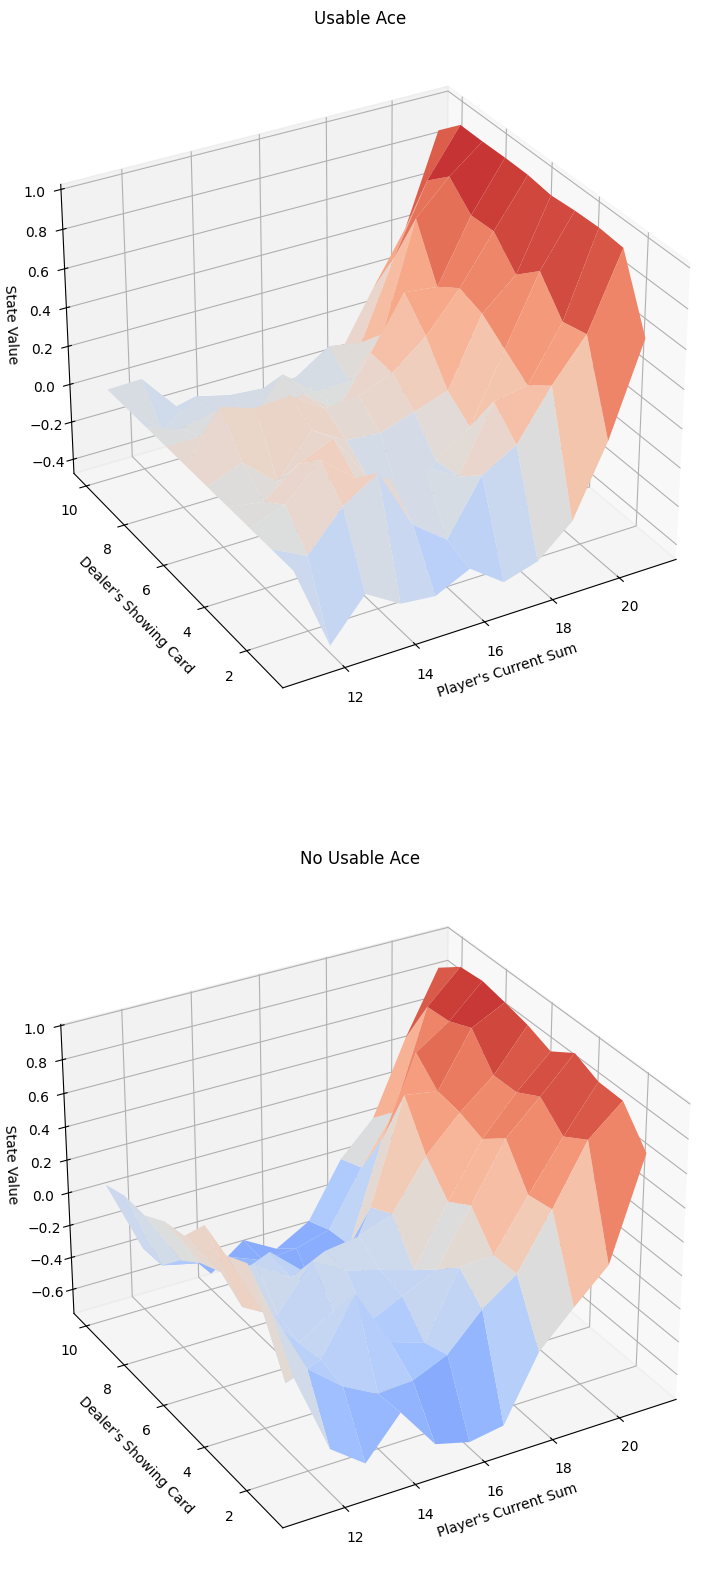

In [29]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

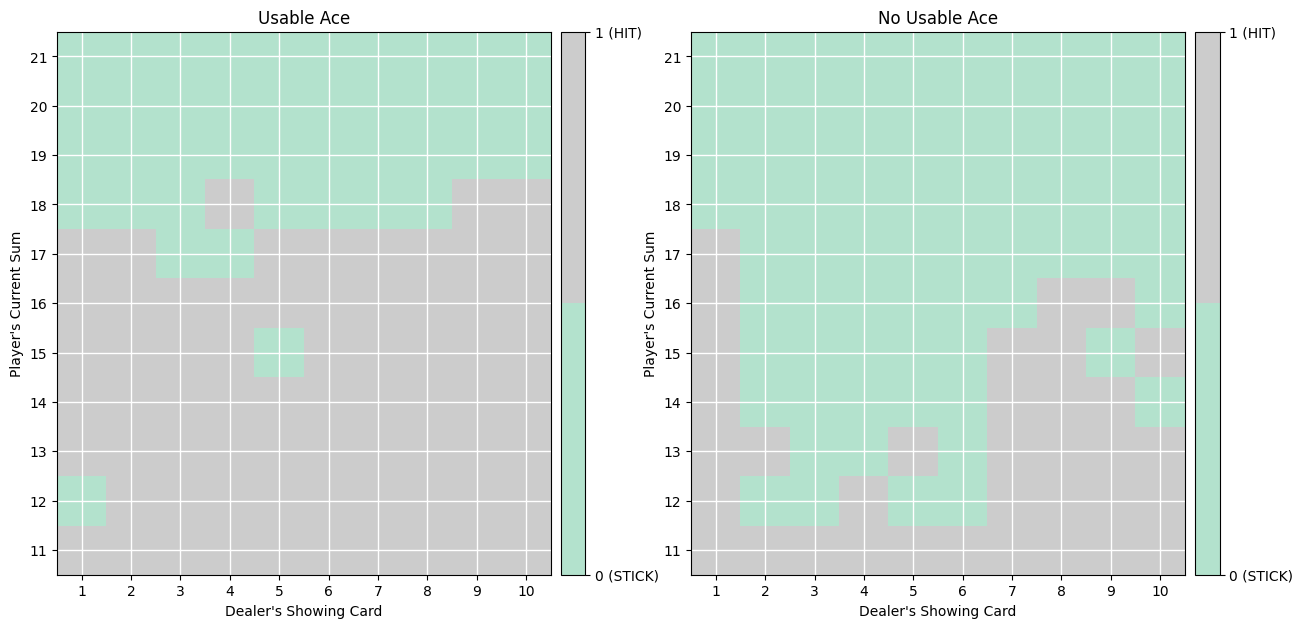

In [30]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare final estimate to the optimal policy - it looks very similar. Certainly, we can take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

### Discussion

**Monte Carlo's Critical Limitation:**

Monte Carlo methods fundamentally require complete episodes to learn, as they need to calculate returns at the end of each episode. This creates a significant limitation in real-world applications where waiting for episode completion is impractical or dangerous. For instance, in self-driving scenarios, it would mean the car needs to crash to learn about dangerous situations.

So, we need to introduce new method to learning at every step rather than waiting for episode completion and making immediate value updates based on estimates, allowing for real-time learning.

See details in notebook [Temporal Difference(TD) Learning](../temporal-difference-methods/temporal-difference.ipynb)